## Index ##
- Einleitung
- Einfuehrung des SEIR Models
- Erweiterung des SEIR Models: Mathematische Erkl&auml;rung
  - Das SEIIRHQ-Modell
  - Das SSSEIIRHQ-Modell
- Umsetzung des Modells in Python
  - Vorlage (Beschreibung der Vorlage, Euler etc.)
  - Anpassung der Vorlage (code)
- Kommentierung der Ergebnisse
- Vergleich mit reellen Daten
- Quellen


## Einleitung

In diesem Jupyter-Notebook beschäftigen wir uns mit dem sogenannten SEIR-Modell. Vorrangig geht es hierbei um die algorithmische Umsetzung dieses Modells in Python, unter besonderer Berücksichtigung von Python-Erweiterungen, die im Bereich wissenschaftlicher Programmierung genutzt werden. 
Zunächst soll kurz vorgestellt werden, worum es sich bei SEIR handelt. Anschließend werden Code-Beispiele präsentiert, die die Umsetzung des SEIR-Algorithmus in Python verdeutlichen sollen. Zum Abschluss werden eigene Erweiterungen für das SEIR-Modell präsentiert, die eine bessere Abbildung des Pandemiegeschehens durch Maßnahmen wie Impfung, Qurantäne-Anordnungen etc.leisten sollen. Teile des Codes wurden von https://github.com/m-schmidt-math-opt/covid-19-extended-seir-model übernommen und überarbeitet. Die theoretische Grundlage der Überarbeitung stellt zudem das Paper von He et. al. 2020 (https://www.nature.com/articles/s41598-021-83540-2) dar. Aus diesen Paper wurden die Ideen für die Erweiterungen des SEIR Modells bezogen und dann in eigene Differenzialgleichungen und Python-Code überführt.
 



#  Einführung SEIR Modell

Das sogenannte SEIR-Modell stellt eine Möglichkeit dar, Pandemie-Verläufe innerhalb von Gesellschaften, wie beispielsweise der deutschen Bevölkerung, zu modellieren und wurde auch für den Verlauf der aktuellen Covid-19-Pandemie benutzt, um Vorhersagen über die Entwicklung und den weiteren Verlauf sowie die Wirksamkeit von Gegenmaßnahmen treffen zu können.

Hierbei steht die Abkürzung SEIR für:

**S**usceptible (Gefährdete, Nicht-Infizierte)

**E**xposed (Infizierte, aber selbst noch nicht infektiös)

**I**nfectious (Infektiöse)

**R**ecovered (Genesene, nicht mehr infektiös)


Die gesamte Bevölkerung einer Gesellschaft lässt sich in eine dieser Gruppen einteilen und die Summe S+E+I+R=N entspricht dabei der Gesamtzahl N der Individuen ebendieser. Mithilfe von vier Differenzialgleichungen lässt sich die Zunahme und Abnahme innerhalb dieser vier Gruppen abbilden. Das Lösen besagter Differenzialgleichungen erfolgt in unseren Beispielen sowie in den in der Literatur gefundenen Code-Sampeln mithilfe des expliziten Euler-Vefahrens, einem simplen Algorithmus zur numerischen Lösung von Anfangswertproblemen.


Die unten aufgeführten Formeln entsprechen jeweils der Änderungsrate , also der Ableitung, der vier Kategorien (**S, E, I, R**) pro Zeitschritt. 

Von der Gruppe der anfälligen Personen, **Kategorie S**, wird die Zahl der Personen, die sich innerhalb der Zeiteinheit durchschnittlich aufgrund ihrer Kontakte (entspricht Parameter **β**) infizieren, subtrahiert.

Diese von der Gruppe S abgezogenen, also infizierten Personen werden im gleichen Schritt der **Kategorie E**, was der Zahl der infizierten, aber noch nicht infektiösen Zahl an Menschen betrifft, zugeschlagen, wobei wiederum diejenigen, die gerade infektiös geworden sind (abhängig vom Parameter **θ**), von dieser Gruppe abgezogen werden.

Besagte infektiös Infizierte werden nun der **Kategorie I** zugeschlagen, von der in einem weiteren Schritt alle Genesenen (ermittelt durch Parameter **γ**) abgezogen werden.

Die Genesenen landen dauerhaft in **Kategorie R**.

Die Parameter $\beta$, $\theta$ und $\gamma$ geben bei allen Übergängen jeweil an, wie viele Personen von einer Kategorie im nächsten Zeitschritt durchschnittlich in eine andere Kategorie übergehen. Die genauen Werte für diese Parameter müssen empirisch durch Fachwissenschaftler ermittelt werden und unterliegen einer gewissen Unsicherheit. Allerdings lässt sich jeder Wert innerhalb unserer Algorithmen beliebig anpassen.

##Formeln

$\dot S = - \frac{1}{N} \beta S I$

$\dot E = \frac{1}{N} \beta S I - \theta E$

$\dot I = \theta E - \gamma I$

$\dot R = \gamma I $
 
wobei:

|Variable|Beschreibug|
|--------|-----------|
|S(t)|Anteil der Anfälligen, engl. susceptible. Noch nicht infiziert.|
|E(t)|Anteil der Exponierten, engl. exposed. Infiziert, aber noch nicht infektiös.|
|I(t)|Anteil der Infektiösen, engl. infectious.|
|R(t)|Anteil der Erholten, engl. recovered oder resistant. Bzw. verstorben oder nach Symptomen in Quarantäne.|


und 

|Parameter|Beschreibung|
|---------|------------|
|$\beta$|Transmissionsrate. Der Kehrwert ist die mittlere Zeit zwischen Kontakten mit Übertragung.|
|$\gamma$|Erholungsrate. Der Kehrwert ist die mittlere infektiöse Zeit. |
|$\theta$|Übergangsrate. Der Kehrwert ist die mittlere Latenzzeit.|


In [139]:
from numpy import array as vector
import numpy as np

class SEIR_Model:
    """
    SEIR Basismodell: Die Einfachste Form des SEIR Modells als Baseline, ohne weitere Differenzierung
    der Gruppen
    """

    def __init__(self, packed_parameters):
        if test: print("Running in test mode.")
        print("Instantiate the SEIR model ...")
        
        self.n = packed_parameters[0]
        self.beta = packed_parameters[1]
        self.theta = packed_parameters[2]
        self.gamma = packed_parameters[3]
        self.x0 = packed_parameters[4]

        self.numerical_tolerance_fine = 1e-2 # todo
        self.numerical_tolerance_coarse = 1e-2

    def eval_rhs(self, x_t):
        s, e, i, r = x_t

        # Sanity checks
        if test: assert(abs(sum(x_t) - sum(self.x0)) < self.numerical_tolerance_coarse)
        
        x_t_1 = vector([
            -self.beta*(s/self.n)*i,
            self.beta*(s/self.n)*i - self.theta*e,
            self.theta*e - self.gamma*i,
            self.gamma*i
        ])

        # Sanity checks
        if test: 
            assert(abs(sum(x_t_1)) < self.numerical_tolerance_fine)

        return x_t_1

# class SEIR_Model

## Erweiterungen des SEIR-Modells

Das SEIR-Modell stellt eine erste Annäherung an die Entwicklung des Geschehens einer Pandemie wie Covid-19 dar. Die drei Parameter (β, γ und θ) können dabei beliebig modifiziert werden, je nach dem, welche Werte dafür von wissenschaftlicher Seite präferiert werden. Doch das Modell stößt schnell an seine Grenzen und wird der Komplexität einer Pandemie nicht vollständig gerecht. Es ergeben sich folgende Beschränkungen:

  -  Es wird nicht zwischen den Parametern verschiedener sozialer Gruppen unterschieden.
  -  Die Möglichkeit einer Impfung fließt nicht in die Berechnungen mit ein.
  -  Genese gelten dauerhaft als immun gegen die Krankheit.
  -  Die Möglichkeit, gefährdete oder infizierte Personen in Quarantäne zu schicken, wird nicht berücksichtigt.
  -  Der Grad der Hospitalisierung, d.h. der Anteil der Menschen mit einer ernstzunehmenden Erkrankung, findet keine Beachtung

Im Folgenden soll nun das SEIR-Modell um einige Zusatzannahmen erweitert werden und algorithmisch in Python umgesetzt werden. Die Anregungen für die Erweiterung des Modells übernehmen wir aus: (https://link.springer.com/content/pdf/10.1007/s11071-020-05743-y.pdf). Die algorithmische Umsetzung in Python erfolgt durch uns. Es ergeben sich dann die unten aufgeführten (modifizierten und komplexeren) Differenzialgleichungen, die wiederum numerisch, z. B. mit dem Euler-Verfahren, gelöst werden können. 

## Das SEIIRHQ Modell

Im SEIR-Modell wird die Anzahl der hospitalisiserter Patienten berechnet. Außerdem wir die Einführung von Quarantänemaßnahmen berücksichtig. Es wird daher unterschieden zwischen Personen mit "Intervention" (Quarantäne/Hospitalisierung) sowie Patienten ohne Intervention. Diese Patienten nehmen weiter am gesellschaftlichen Leben teil, obwohl sie krank und ansteckend sind, und stecken daher andere Personen mit erhöhter Wahrscheinlichkeit an.

Weiterhin wird die Tatsache berücksichtigt, dass Patienten, die bereits angesteckt waren und wieder genesen sind ("recovered"), sich ein weiteres Mal anstecken können. Diese Übergangsrate wird mit dem Parameter **$\alpha$** simuliert


##Formeln 


$\dot S = - \frac{S}{N} (\beta_1 I_1 + \beta_2 I_2 + \chi E) + \rho_1 Q - \rho_2 S + \alpha R$

$\dot E = \frac{S}{N} (\beta_1 I_1 + \beta_2 I_2 + \chi E) - \theta_1 E - \theta_2 E$

$\dot I_1 = \theta_1 E - \gamma_1 I_1$

$\dot I_2 = \theta_2 E - \gamma_2 I_2 - \phi I_2 + \lambda (\Lambda + Q)$

$\dot R = \gamma_1 I_1 + \gamma_2 I_2 + \psi H - \alpha R$

$\dot H = \phi I_2 - \psi H$

$\dot Q = \Lambda + \rho_2 S - \lambda (\Lambda + Q) - \rho_1 Q$

 
wobei:

|Variable|Beschreibug|
|--------|-----------|
|$S$|Anfällige|
|E|Exponierte|
|$I_1$|Infizierte ohne Behandlung|
|$I_2$|Infizierte mit Behandlung|
|R|Genesen|
|H|Hospitalisiert|
|Q|Unter Quarantäne gestellt|

und 

|Parameter|Beschreibung|
|---------|------------|
|$\alpha$|Vorübergehende Immunitätsrate|
|$\beta_1, \beta_2$|Die Kontakt- und Infektionsrate der Übertragung pro Kontakt mit einer infizierten Klasse|
|$\gamma_1, \gamma_2$|Genesungsrate von symptomatischen infizierten Personen zu genesenen|
|$\chi$|Wahrscheinlichkeit der Übertragung pro Kontakt durch exponierte Personen bei ungeimpften Personen|
|$\lambda$|Verhältnis zwischen der unter Quarantäne gestellten Gruppe und der genesenen Gruppe|
|$\Lambda$|Externer Beitrag aus dem Ausland|
|$\rho_1, \rho_2$|Übergangsrate von den unter Quarantäne gestellt exponierten Personen zwischen der unter Quarantäne gestellten infizierten Gruppe und der Allgemeinheit|
|$\theta_1, \theta_2$|Übergangsrate von exponierten Personen in die Klasse der Infizierten|
|$\phi$|Anteil der infektiösen Personen mit Symptomen, die ins Krankenhaus eingeliefert werden|
|$\psi$|Genesungsrate der unter Quarantäne stehenden infizierten Personen|


In [140]:
from numpy import array as vector
import numpy as np
import random


class SEIIRHQ_Model:
    """
    Anpassung des SEIR Modells. Zusätzlich zum SEIR Modell wird hier die Anzahl hospitalisierter Patienten berücksichtig (H). Außerdem werden
    die Infizierten Personen (I) nach Behandlungsbedürftigen Patienten und nicht behandlungsbedürftigen Patienten unterteilt
    """

    def __init__(self, packed_parameters):
        if test: print("Running in test mode.")
        print("Instantiate the SEIIRHQ model ...")
        
        self.n = packed_parameters[0]             # total of individuals   
        self.beta_no_intv = packed_parameters[1]  # The contact and infection rate of transmission per contact from the infected without intervention class
        self.beta_intv = packed_parameters[2]     # The contact and infection rate of transmission per contact from the infected with intervention class 
        self.theta_no_intv = packed_parameters[3] # Transition rate of exposed individuals to the infected without intervention class
        self.theta_intv = packed_parameters[4]    # Transition rate of exposed individuals to the infected with intervention class
        self.gamma_no_intv = packed_parameters[5] # Recovery rate of symptomatic infected without intervention to recovered
        self.gamma_intv = packed_parameters[6]    # Recovery rate of symptomatic infected with intervention to recovered
        self.alpha  = packed_parameters[7]        # Temporary immunity rate
        self.rho_in = packed_parameters[8]        # Transition rate between the subsceptible class and quarantined class
        self.rho_out = packed_parameters[9]       # Transition rate between the quarantined class and the susceptible class
        self.chi = packed_parameters[10]          # Probability of transmission per contact from exposed individuals
        self.phi = packed_parameters[11]          # Rate of infectious with symptoms to hospitalized
        self.lbda = packed_parameters[12]         # Rate of the quarantined class to the infectious class with intervention
        self.psi = packed_parameters[13]          # Recovered rate of hospitalized / quarantined infected individuals
        self.x0 = packed_parameters[14]           # seiirhq at time 0
        self.total_immigrants=0
        self.i=0

        self.numerical_tolerance_fine = 10 # 
        self.numerical_tolerance_coarse = 1e-2

    def eval_rhs(self, x_t):
        s, e, i_no_intv, i_intv, r, h, q = x_t
        
        immigrants=random.uniform(1000, 10000)
        self.total_immigrants=self.total_immigrants+immigrants
        
        factor = (s / self.n) * (self.beta_no_intv * i_no_intv + self.beta_intv * i_intv + self.chi * e)
        
        # [s, e, i_no_intv, i_intv, r, h, q]
        x_t_1 = vector([
            -factor + self.rho_out*q - self.rho_in*s + self.alpha*r,   # S
            factor - self.theta_no_intv*e - self.theta_intv*e,    # E
            self.theta_no_intv*e - self.gamma_no_intv*i_no_intv,    # I without intervention
            self.theta_intv*e - self.gamma_intv*i_intv - self.phi*i_intv + self.lbda*(immigrants + q),    # I with intervention
            self.gamma_no_intv*i_no_intv + self.gamma_intv*i_intv + self.psi*h - self.alpha*r,   # R
            self.phi*i_intv-self.psi*h,   # H
            immigrants + self.rho_in*s - self.rho_out*q  - self.lbda*q   # Q
        ])

        # Sanity checks
        if test: assert(abs(sum(x_t_1)-(immigrants+(self.lbda*(immigrants)))) < self.numerical_tolerance_fine)
          
        return x_t_1

# class SEIIRHQ_Model



```
# Als Code formatiert
```


## Das SSSEIIRHQ-Modell
Das SEIIRHQ-Modell wird nun um weitere Kategorien erweitert. Der Gruppe der anfälligen Personen wird nun dreigeteilt: zum einen wird zwischen ungeimpften (**S1**) und geimpften Erwachsenen (**S2**) unterschieden, zum anderen wird die Kategorie 'Kinder' (**S3**) hinzugefügt. Diese neue Unterteilung macht Sinn, da nun verschiedenen sozialen Gruppen unterschiedliche Parameter zugewiesen werden können. Die Zahl und die Komplexität der benutzten Differenzialgleichungen nimmt dadurch zu. Die hierzu verwendeten Formeln sind hier aufgeführt und sollen durch das Schaubild darunter verdeutlicht werden.

##Formeln 


$\dot S_1 = - \frac{S_1}{N} (\beta_{1_{novaccined}} I_1 + \beta_{2_{novaccined}} I_2 + \chi_{novaccined} E) + \rho_1 Q - \rho_2 S_1 + \epsilon S_2 - \epsilon S_1 + \alpha (1 - \eta) R  $ 

$\dot S_2 = - \frac{S_2}{N} (\beta_{1_{vaccined}} I_1 + \beta_{2_{vaccined}} I_2 + \chi_{vaccined} E) + \rho_1 Q - \rho_2 S_2 - \epsilon S_2 + \epsilon S_1 $

$\dot S_3 = - \frac{S_3}{N} (\beta_{1_{children}} I_1 + \beta_{2_{children}} I_2 + \chi_{children} E) + \rho_1 Q - \rho_2 S_3 + \alpha \eta R$


$\dot E = \frac{(S_1+S_2+S_3)}{N} ((\beta_{1_{novaccined}} + \beta_{1_{vaccined}} + \beta_{1_{children}}) I_1 + (\beta_{2_{novaccined}} + \beta_{2_{vaccined}} + \beta_{2_{children}}) I_2 + (\chi_{novaccined} + \chi_{vaccined} + \chi_{children}) E) - \theta_1 E - \theta_2 E$

$\dot I_1 = \theta_1 E - \gamma_1 I_1$

$\dot I_2 = \theta_2 E - \gamma_2 I_2 - \phi I_2 + \lambda (\Lambda + Q)$

$\dot R = \gamma_1 I_1 + \gamma_2 I_2 + \psi H - \alpha R$

$\dot H = \phi I_2 - \psi H$

$\dot Q = \rho_2 (S_1 + S_2 + S_3) - \lambda Q - \rho_1 Q$

 
wobei:

|Variable|Beschreibug|
|--------|-----------|
|$S_1$|Anfällige Klasse der ungeimpften Erwachsenen|
|$S_2$|Anfällige Klasse der geimpften Erwachsenen|
|$S_3$|Anfällige Klasse der ungeimpften Kindern|
|E|Exponierte|
|$I_1$|Infizierte ohne Behandlung|
|$I_2$|Infizierte mit Behandlung|
|R|Genesen|
|H|Hospitalisiert|
|Q|Unter Quarantäne gestellt|

und 

|Parameter|Beschreibung|
|---------|------------|
|$\alpha$|Vorübergehende Immunitätsrate|
|$\beta_1, \beta_2$|Die Kontakt- und Infektionsrate der Übertragung pro Kontakt mit einer infizierten Klasse|
|$\gamma_1, \gamma_2$|Genesungsrate von symptomatischen infizierten Personen zu genesenen|
|$\chi$|Wahrscheinlichkeit der Übertragung pro Kontakt durch exponierte Personen bei ungeimpften Personen|
|$\lambda$|Verhältnis zwischen der unter Quarantäne gestellten Gruppe und der genesenen Gruppe|
|$\rho_1, \rho_2$|Übergangsrate von den unter Quarantäne gestellt exponierten Personen zwischen der unter Quarantäne gestellten infizierten Gruppe und der Allgemeinheit|
|$\theta_1, \theta_2$|Übergangsrate von exponierten Personen in die Klasse der Infizierten|
|$\phi$|Anteil der infektiösen Personen mit Symptomen, die ins Krankenhaus eingeliefert werden|
|$\psi$|Genesungsrate der unter Quarantäne stehenden infizierten Personen|
|$\epsilon$|Impfungsrate|
|$\eta$|Prozent von Kindern insgesamt|


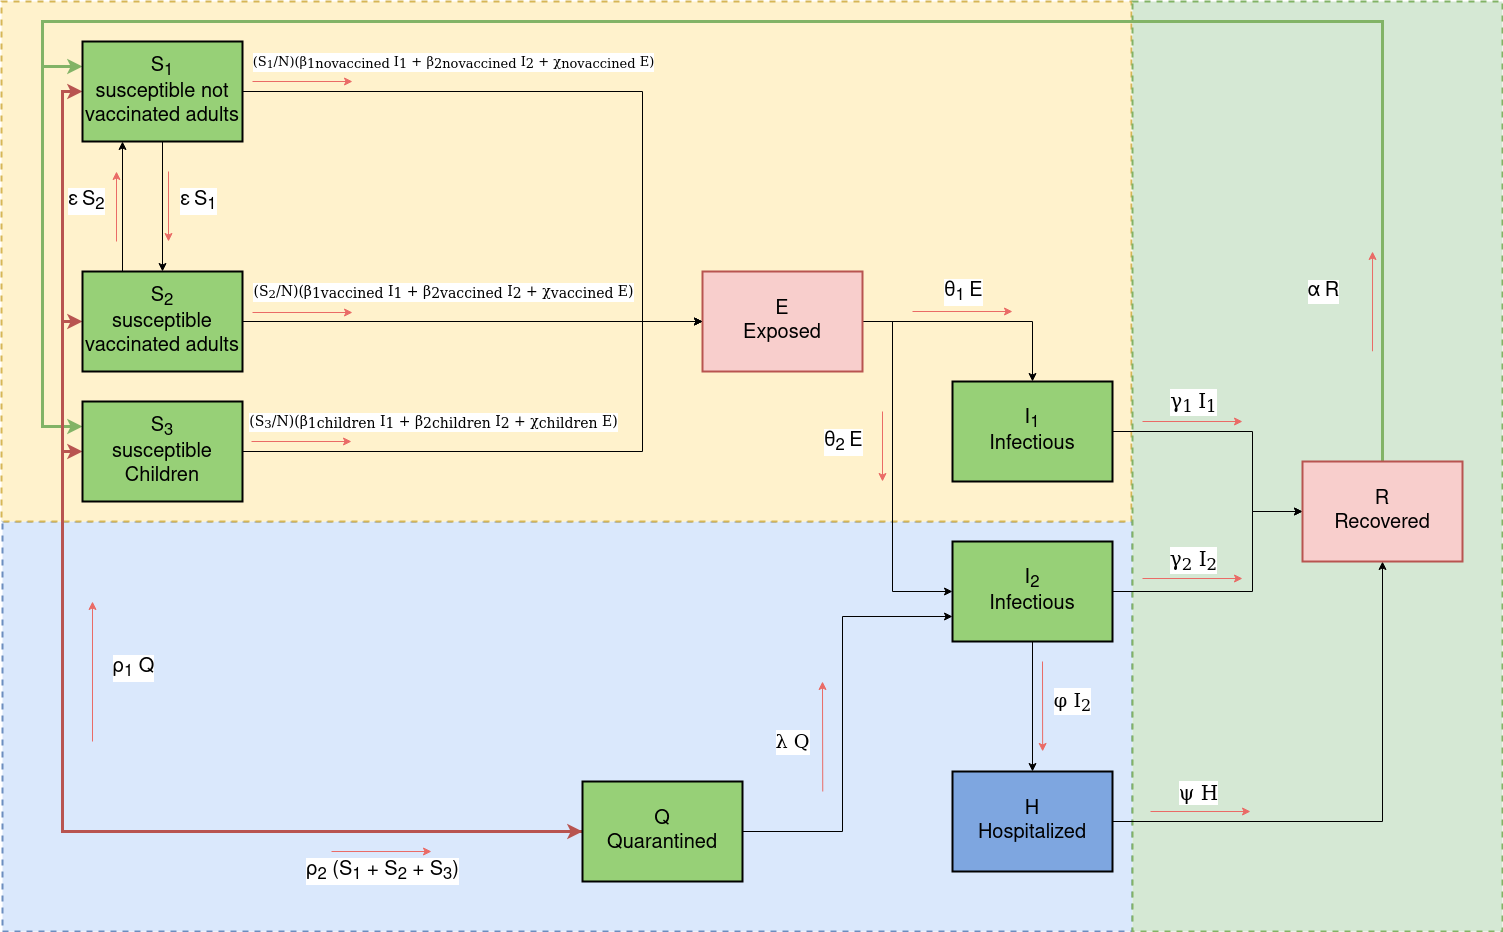

In [141]:
from IPython.display import Image

Image('./images/COVID_Math_Model.png')

In [142]:
from numpy import array as vector
import numpy as np

class SSSEIIRHQ_Model:
    """
    Die Klasse SSSEIIRHQ_Modell repräsentiert das SSSEIIRHQModell innerhalb des Programms. 
    In ihr sind alle Formeln(Differenzialgleichungen) notiert, die wichtig sind für dieses Modell 
    und die die Übergänge zwischen den Kategorien beschreiben. 
    Sie wird der Klasse Explizit_Euler übergeben für die weitere Berechnung. 
    """

    #Im Konstruktor werden die gepackten Werte für die Berechnungsparamter (alpha, beta, gamma etc.) sowie die jeweiligen Gruppengrößen 
    #für die einzelnen Kategorien übergeben und entsprechenden Klassen-Variablen zugeordnet.
    def __init__(self, packed_parameters):
        print("Instantiate the SSSEIIRHQ model ...")
        if test: print("Running in test mode.")
        
        self.n = packed_parameters[0]             # total of individuals   
        self.beta_no_intv = packed_parameters[1]  # The contact and infection rate of transmission per contact from the infected without intervention class
        self.beta_intv = packed_parameters[2]     # The contact and infection rate of transmission per contact from the infected with intervention class 
        self.theta_no_intv = packed_parameters[3] # Transition rate of exposed individuals to the infected without intervention class
        self.theta_intv = packed_parameters[4]    # Transition rate of exposed individuals to the infected with intervention class
        self.gamma_no_intv = packed_parameters[5] # Recovery rate of symptomatic infected without intervention to recovered
        self.gamma_intv = packed_parameters[6]    # Recovery rate of symptomatic infected with intervention to recovered
        self.alpha  = packed_parameters[7]        # Temporary immunity rate
        self.rho_in = packed_parameters[8]        # Transition rate between the subsceptible class and quarantined class
        self.rho_out = packed_parameters[9]       # Transition rate between the quarantined class and the susceptible class
        self.chi = packed_parameters[10]          # Probability of transmission per contact from exposed individuals
        self.phi = packed_parameters[11]          # Rate of infectious with symptoms to hospitalized
        self.lbda = packed_parameters[12]         # Rate of the quarantined class to the infectious class with intervention
        self.psi = packed_parameters[13]          # Recovered rate of hospitalized / quarantined infected individuals
        self.epsilon = packed_parameters[14]      # Impfungsrate
        self.eta = packed_parameters[15]          # Prozent von Kindern
        
        self.x0 = packed_parameters[16]           # ssseiirhq at time 0

        self.numerical_tolerance_fine = 1e-2 # todo
        self.numerical_tolerance_coarse = 1e-2


    #Die Werte für die einzelnen Parameter und die Gruppengröße der Kategorien werden in Form eines Vektors übergeben. 
    #Die Werte für die Kategorien werden entsprechend der hinterlegten Formeln aktualisiert und in Form eines Vektors zurückgegeben.
    def eval_rhs(self, x_t):
        s_no_v, s_v, s_ch, e, i_no_intv, i_intv, r, h, q = x_t
        
        # Sanity checks
        if test: assert(abs(sum(x_t) - sum(self.x0)) < self.numerical_tolerance_coarse)

        factor_no_v = (s_no_v / self.n) * (self.beta_no_intv[0] * i_no_intv + self.beta_intv[0] * i_intv + self.chi[0] * e)
        factor_v = (s_v / self.n) * (self.beta_no_intv[1] * i_no_intv + self.beta_intv[1] * i_intv + self.chi[1] * e)
        factor_ch = (s_ch / self.n) * (self.beta_no_intv[2] * i_no_intv + self.beta_intv[2] * i_intv + self.chi[2] * e)
        
        # [s_no_v, s_v, s_ch, e, i_no_intv, i_intv, r, h, q]
        x_t_1 = vector([
            -factor_no_v + self.rho_out*s_no_v/(s_no_v+s_v+s_ch)*q - self.rho_in*s_no_v + (self.alpha*r*(1.00 - self.eta)) - self.epsilon*s_no_v + self.epsilon*s_v,   # S not vaccined
            -factor_v + self.rho_out*s_v/(s_no_v+s_v+s_ch)*q - self.rho_in*s_v - self.epsilon*s_v + self.epsilon * s_no_v,   # S vaccined
            -factor_ch + self.rho_out*s_ch/(s_no_v+s_v+s_ch)*q - self.rho_in*s_ch + self.alpha*self.eta*r,   # S children
            (factor_no_v + factor_v + factor_ch) - self.theta_no_intv*e - self.theta_intv*e,    # E
            self.theta_no_intv*e - self.gamma_no_intv*i_no_intv,    # I without intervention
            self.theta_intv*e - self.gamma_intv*i_intv - self.phi*i_intv + self.lbda*q,    # I with intervention
            self.gamma_no_intv*i_no_intv + self.gamma_intv*i_intv + self.psi*h - self.alpha*r,   # R
            self.phi*i_intv-self.psi*h,   # H
            self.rho_in*(s_no_v + s_v + s_ch) - self.rho_out*q  - self.lbda*q   # Q
        ])

        # Sanity checks
        if test:
            assert(abs(sum(x_t_1)) < self.numerical_tolerance_fine) #Test, ob Abgänge und Zugänge über alle Gruppen hinweg ausgleichen

        return x_t_1

# class SSSEIIRHQ_Model

Die **Klasse Data_Reader** stellt die Funktionalitäten für das Auslesen der Datensätze aus einer cSV-Datei zur Verfügung.

In [143]:
from numpy.lib.function_base import hamming
from numpy import array as vector
from numpy import matrix as matrix
import numpy as np
import csv

class Data_Reader:
    """
    Die Data_Reader-Klasse zum Auslesen der Daten aus einer csv-Datei. Für jedes Modell
    existiert eine eigene Funktion, die die entsprechenden Daten, die das Modell benötigt,
    zurückliefert.
    """

    #Auslesen und Zurückgeben der Daten für das SEIR-Modell
    def read_seir_from_csv_file(self, filename):
        print("Parse SEIR data from CSV file " + filename + " ...")

        with open(filename, encoding='utf-8-sig') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=";")
            
            for row in csv_reader:
                #Parameters
                if row[0] == "beta":
                    beta = float(row[1].replace(",","."))
                elif row[0] == "theta":
                    theta = float(row[1].replace(",","."))
                elif row[0] == "gamma":
                    gamma = float(row[1].replace(",","."))
        
                #SEIR
                elif row[0] == "N":
                    n = float(row[1].replace(",","."))
                elif row[0] == "S":
                    s = float(row[1].replace(",","."))
                elif row[0] == "E":
                    e = float(row[1].replace(",","."))
                elif row[0] == "I":
                    i = float(row[1].replace(",","."))
                elif row[0] == "R":
                    r = float(row[1].replace(",","."))
                    
                else:
                    print("Unknown data field: " + str(row[0]))
                    assert(False)

        x0 = (s, e, i, r)
        packed_data = [ n, 
                        beta,
                        theta,
                        gamma,
                        x0 ]

        return packed_data

    # Read SEIIRHQ Model
    def read_seiirhq_from_csv_file(self, filename):
        print("Parse SEIIRHQ data from CSV file " + filename + " ...")

        with open(filename, encoding='utf-8-sig') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=";")

            for row in csv_reader:
                #Parameters
                if row[0] == "beta_no_intv":
                    beta_no_intv = float(row[1].replace(",","."))
                elif row[0] == "beta_intv":
                    beta_intv = float(row[1].replace(",","."))
                elif row[0] == "theta_no_intv":
                    theta_no_intv = float(row[1].replace(",","."))
                elif row[0] == "theta_intv":
                    theta_intv = float(row[1].replace(",","."))
                elif row[0] == "gamma_no_intv":
                    gamma_no_intv = float(row[1].replace(",","."))
                elif row[0] == "gamma_intv":
                    gamma_intv = float(row[1].replace(",","."))
                elif row[0] == "alpha":
                    alpha = float(row[1].replace(",","."))
                elif row[0] == "rho_in":
                    rho_in = float(row[1].replace(",","."))
                elif row[0] == "rho_out":
                    rho_out = float(row[1].replace(",","."))
                elif row[0] == "chi":
                    chi = float(row[1].replace(",","."))
                elif row[0] == "phi":
                    phi = float(row[1].replace(",","."))
                elif row[0] == "lambda":
                    lbda = float(row[1].replace(",","."))
                elif row[0] == "psi":
                    psi = float(row[1].replace(",","."))

                #SEIIRHQ
                elif row[0] == "N":
                    n = float(row[1].replace(",","."))
                elif row[0] == "S":
                    s = float(row[1].replace(",","."))
                elif row[0] == "E":
                    e = float(row[1].replace(",","."))
                elif row[0] == "I_no_intv":
                    i_no_intv = float(row[1].replace(",","."))
                elif row[0] == "I_intv":
                    i_intv = float(row[1].replace(",","."))
                elif row[0] == "R":
                    r = float(row[1].replace(",","."))
                elif row[0] == "H":
                    h = float(row[1].replace(",","."))
                elif row[0] == "Q":
                    q = float(row[1].replace(",","."))
                    
                else:
                    print("Unknown data field: " + str(row[0]))
                    assert(False)

        x0 = (s, e, i_no_intv, i_intv, r, h, q)

        packed_data = [n,              # total of individuals   
                      beta_no_intv,     # The contact and infection rate of transmission per contact from the infected without intervention class
                      beta_intv,        # The contact and infection rate of transmission per contact from the infected with intervention class 
                      theta_no_intv,    # Transition rate of exposed individuals to the infected without intervention class
                      theta_intv,       # Transition rate of exposed individuals to the infected with intervention class
                      gamma_no_intv,    # Recovery rate of symptomatic infected without intervention to recovered
                      gamma_intv,       # Recovery rate of symptomatic infected with intervention to recovered
                      alpha,            # Temporary immunity rate
                      rho_in,           # Transition rate between the subsceptible class and quarantined class
                      rho_out,          # Transition rate between the quarantined class and the susceptible class
                      chi,              # Probability of transmission per contact from exposed individuals
                      phi,              # Rate of infectious with symptoms to hospitalized
                      lbda,             # Rate of the quarantined class to the infectious class with intervention
                      psi,              # Recovered rate of hospitalized / quarantined infected individuals
                      x0]                # time 0

        return packed_data


    # Read SSSEIIRHQ Model
    def read_ssseiirhq_from_csv_file(self, filename):
        print("Parse SSSEIIRQH data from CSV file " + filename + " ...")

        with open(filename, encoding='utf-8-sig') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=";")

            for row in csv_reader:
                #Parameters
                if row[0] == "beta_no_intv":
                    beta_no_intv = vector(self._to_float(row[1:4]))
                elif row[0] == "beta_intv":
                    beta_intv = vector(self._to_float(row[1:4]))
                elif row[0] == "theta_no_intv":
                    theta_no_intv = float(row[1].replace(",","."))
                elif row[0] == "theta_intv":
                    theta_intv = float(row[1].replace(",","."))
                elif row[0] == "gamma_no_intv":
                    gamma_no_intv = float(row[1].replace(",","."))
                elif row[0] == "gamma_intv":
                    gamma_intv = float(row[1].replace(",","."))
                elif row[0] == "alpha":
                    alpha = float(row[1].replace(",","."))
                elif row[0] == "rho_in":
                    rho_in = float(row[1].replace(",","."))
                elif row[0] == "rho_out":
                    rho_out = float(row[1].replace(",","."))
                elif row[0] == "chi":
                    chi = vector(self._to_float(row[1:4]))
                elif row[0] == "phi":
                    phi = float(row[1].replace(",","."))
                elif row[0] == "lambda":
                    lbda = float(row[1].replace(",","."))
                elif row[0] == "psi":
                    psi = float(row[1].replace(",","."))
                elif row[0] == "epsilon":
                    epsilon = float(row[1].replace(",","."))
                elif row[0] == "eta":
                    eta = float(row[1].replace(",","."))
 
                #SSSEIIRHQ
                elif row[0] == "N":
                    n = float(row[1].replace(",","."))

                elif row[0] == "S_not_vaccined":
                    s_no_v = float(row[1].replace(",","."))
                elif row[0] == "S_vaccined":
                    s_v = float(row[1].replace(",","."))
                elif row[0] == "S_children":
                    s_ch = float(row[1].replace(",","."))
            
                elif row[0] == "E":
                    e = float(row[1].replace(",","."))
                elif row[0] == "I_no_intv":
                    i_no_intv = float(row[1].replace(",","."))
                elif row[0] == "I_intv":
                    i_intv = float(row[1].replace(",","."))
                elif row[0] == "R":
                    r = float(row[1].replace(",","."))
                elif row[0] == "H":
                    h = float(row[1].replace(",","."))
                elif row[0] == "Q":
                    q = float(row[1].replace(",","."))
                    
                else:
                    print("Unknown data field: " + str(row[0]))
                    assert(False)

        x0 = (s_no_v, s_v, s_ch, e, i_no_intv, i_intv, r, h, q)

        packed_data = [n,              # total of individuals   
                      beta_no_intv,     # The contact and infection rate of transmission per contact from the infected without intervention class
                      beta_intv,        # The contact and infection rate of transmission per contact from the infected with intervention class 
                      theta_no_intv,    # Transition rate of exposed individuals to the infected without intervention class
                      theta_intv,       # Transition rate of exposed individuals to the infected with intervention class
                      gamma_no_intv,    # Recovery rate of symptomatic infected without intervention to recovered
                      gamma_intv,       # Recovery rate of symptomatic infected with intervention to recovered
                      alpha,            # Temporary immunity rate
                      rho_in,           # Transition rate between the subsceptible class and quarantined class
                      rho_out,          # Transition rate between the quarantined class and the susceptible class
                      chi,              # Probability of transmission per contact from exposed individuals
                      phi,              # Rate of infectious with symptoms to hospitalized
                      lbda,             # Rate of the quarantined class to the infectious class with intervention
                      psi,              # Recovered rate of hospitalized / quarantined infected individuals
                      epsilon,           # Impfungsrate
                      eta,              # Prozent von Kindern
                      x0]                # time 0

        return packed_data

    def _to_float(self, my_list):
        return [float(x.replace(",",".")) for x in my_list]

# class Data_Reader


## Explizites Euler-Verfahren


Gelöst werden diese Differenzialgleichungen nun entweder analytisch, wenn klar ist, ob eine Stammfunktion hierzu existiert, oder mithilfe numerischer Verfahren, wenn letzteres unmöglich oder zu aufwendig ist. Das simpelste Verfahren zur Annäherung an die exakte Lösung einer Differenzialgleichung, stellt das Euler-Verfahren dar - welches auch bei unseren Berechnungen Anwendung findet. Bei diesem Algorithmus wird zunächst eine Schrittweite festgelegt, die die Anzahl der Rechenschritte festlegt und gleichzeitig den Grad der Genauigkeit der Lösung bestimmt. Dann werden ausgehend von dem Anfangswert die Punkte eines Graphen ermittelt. Dies geschieht, indem immer von einem Punkt der Lösungsmenge mithilfe des Produktes aus Schrittweite und Ableitung zu dem nächsten Punkt übergegangen wird. 

Es ergibt sich folgendes Schema: 

    h = Schrittweite
    n = Anzahl der Schritte
	
    x0 = X-Wert des Anfangswertproblems 
    y0 = Y-Wert des Anfangswertproblems

k = 0

Wiederhole:

    xk+1 = x0 + k*h

    yk+1 = yk + h* ḟ(xk)
bis  k = n


In [144]:
 class Explicit_Euler:
    """
    Klasse zur numerischen Berechnung von Differenzialgleichungen.
    Mittels Numpy-Vektor werden in einem Berechnungsschritt immer
    alle Differenzialgleichungen gleichzeitig berechnet    
    in:
    ode = das jeweilige Modell der Differenzialgleichungen (ordinary differential equation): seir, seiirhq, ssseiirhq
    stepsize = Schrittgröße
    """
    def __init__(self, ode, stepsize):
        self.ode = ode
        self.stepsize = stepsize


    #eigentlicher Euler-Algorithmus
    #in:
    #
    #t_start = Beginn des Zeitraums
    #x_start = Vektor mit Startwerten für jede einzelne Kategorie
    #t_end = Ende des Zeitraums
    #
    #out:
    # results = mehrdimensionales Array mit Werten für jede Kategorie pro Zeiteinheit
    def solve(self, t_start, x_start, t_end):
        print("Solve model with explicit Euler scheme ...")
        t = t_start
        x = x_start
        results = [[t, x]]
        nr_of_steps = int((t_end - t_start) / self.stepsize) + 1
        print("Number of steps: " + str(nr_of_steps))
        for k in range(0, nr_of_steps):
            x = x + self.stepsize * self.ode.eval_rhs(x)
            t = t_start + k * self.stepsize
            results.append([t, x])
        return results

# class Explicit_Euler

Mithilfe der Klassen **SEIR_Result_Analyzer, SEIIRHQ_Result_Analyzer und SSSEIIRHQ_Result_Analyzer** werden die vorher berechneten Daten aufbereitet und für die Ausgabe vorbereitet.

In [145]:
class SEIR_Result_Analyzer:
    """
    Die Klasse SEIR_Result_Analyzer erhält die vorher ermittelten Daten aus den Euler-Berechnungen und bereitet sie für die
    weitere Verwendung auf, d.h. für jeden Graphen (S, E, I, R), der später zu sehen sein wird eine Punktmenge generiert, die via matplot angezeigt 
    werden kann. Außerdem wird noch die Dauer der Pandemie berechnet. 
  
    in:
    results = mehrdimensionales Array der per Euler-Verfahren ermittelten Werte für SEIR, jeweils pro Tag
    stepsize = Schrittgröße
    n = Bevölkerung in Deutschland
    t_start = Beginn des Zeitraums
    t_end = Ende des Zeitraums
    """
    def __init__(self, results, stepsize, n, t_start, t_end):
        # Store given values
        self.results = results
        self.stepsize = stepsize
        self.t_start = t_start
        self.t_end = t_end
        self.n = n
        
        # Sanity check
        if test: assert(self.t_start < self.t_end)

        # Preparing empty lists (of lists)
        self.t_vals = []
        self.s_vals = []
        self.e_vals = []
        self.i_vals = []
        self.r_vals = []

        self.i_total = []
        
    #Rückgabe der Werte für S, E, I, R und die Zeitschritte t, als Set of lists        
    def get_extracted_results_as_dict(self):
        result_dict = {}
        result_dict["t_vals"] = self.t_vals
        result_dict["s_vals"] = self.s_vals
        result_dict["e_vals"] = self.e_vals
        result_dict["i_vals"] = self.i_vals
        result_dict["r_vals"] = self.r_vals
               
        return result_dict

    #Aufteilen der Werte für s, e, i, r und die Zeitschritte t auf Listen
    def extract_results(self):
        # Extract and separate results
        for res in self.results:
            if test: assert(len(res) == 2) # entry is of type [t, x]
            self.t_vals.append(res[0])
            
            x = res[1]
            if test: assert(len(x) == 4)
            
            if test: assert(x[0] >= 0.0)
            self.s_vals.append(x[0])

            if test: assert(x[1] >= 0.0)
            self.e_vals.append(x[1])
            
            if test: assert(x[2] >= 0.0)
            self.i_vals.append(x[2])

            if test: assert(x[3] >= 0.0)
            self.r_vals.append(x[3])
        
        self.i_total = self._compute_total_i_cases()

    def _compute_total_i_cases(self):
        i_total = []
        for index, t in enumerate(self.t_vals):
            i_total_at_t = 0.0
            
            if test: assert(len(self.t_vals) == len(self.i_vals))
            if test: assert(self.i_vals[index] >= 0.0)
            if test: assert(self.i_vals[index] <= self.n)
            i_total_at_t += self.i_vals[index]
            
            i_total.append(i_total_at_t)
        if test: assert(len(i_total) == len(self.t_vals))
        return i_total

    def _compute_duration_of_pandemic(self):
        # Compute duration of pandemic
        threshold = 100.0
        time_points_below_threshold = 0
        i_below_at_end = (self.i_total[-1] < threshold)
        for val in reversed(self.i_total):
            if val < threshold:
                time_points_below_threshold += 1
            else:
                break
        number_of_days = self.t_end - self.t_start
        days_below_threshold = time_points_below_threshold * self.stepsize
        duration_of_pandemic = number_of_days - days_below_threshold
        return duration_of_pandemic, i_below_at_end

    def compute_and_write_results(self):
        duration_of_pandemic, i_below_at_end = self._compute_duration_of_pandemic()
        
        print('Dauer der Simulation in Tagen:', self.t_end)

        if duration_of_pandemic < self.t_end:
            print('Dauer der Pandemie:', duration_of_pandemic,'Tage')
        else: 
            print('Dauer der Pandemie: mehr als ', duration_of_pandemic,'Tage')
        
        if i_below_at_end:
            print('Die Pandemie ist am letzen Simulationstag schon beendet.')
        else:
            print('Die Pandemie ist am letzen Simulationstag noch nicht zu Ende')


      
class SEIIRHQ_Result_Analyzer:

    def __init__(self, results, stepsize, n, t_start, t_end):
        # Store given values
        self.results = results
        self.stepsize = stepsize
        self.t_start = t_start
        self.t_end = t_end
        self.n = n
        
        # Sanity check
        if test: assert(self.t_start < self.t_end)

        # Preparing empty lists (of lists)
        self.t_vals = []
        self.s_vals = []
        self.e_vals = []
        self.i_no_intv_vals = []
        self.i_intv_vals = []
        self.r_vals = []
        self.h_vals = []
        self.q_vals = []

        self.i_no_intv_total = []
        
    def get_extracted_results_as_dict(self):
        result_dict = {}
        result_dict["t_vals"] = self.t_vals
        result_dict["s_vals"] = self.s_vals
        result_dict["e_vals"] = self.e_vals
        result_dict["i_no_intv_vals"] = self.i_no_intv_vals
        result_dict["i_intv_vals"] = self.i_intv_vals
        result_dict["r_vals"] = self.r_vals
        result_dict["h_vals"] = self.h_vals
        result_dict["q_vals"] = self.q_vals
               
        return result_dict

    def extract_results(self):
        # Extract and separate results
        for res in self.results:
            
            if test: assert(len(res) == 2) # entry is of type [t, x]
            self.t_vals.append(res[0])
            
            x = res[1]
            
            if test: assert(len(x) == 7)
            
            if test: assert(x[0] >= 0.0)
            self.s_vals.append(x[0])

            if test: assert(x[1] >= 0.0)
            self.e_vals.append(x[1])
            
            if test: assert(x[2] >= 0.0)
            self.i_no_intv_vals.append(x[2])

            if test: assert(x[3] >= 0.0)
            self.i_intv_vals.append(x[3])

            if test: assert(x[4] >= 0.0)
            self.r_vals.append(x[4])

            if test: assert(x[5] >= 0.0)
            self.h_vals.append(x[5])

            if test: assert(x[6] >= 0.0)
            self.q_vals.append(x[6])
        
        self.i_no_intv_total = self._compute_total_i_no_intv_cases()

    def compute_and_write_results(self):
        duration_of_pandemic, i_not_intv_below_at_end = self._compute_duration_of_pandemic()
        
        print('Dauer der Simulation in Tagen:', self.t_end)
        
        if duration_of_pandemic < self.t_end:
            print('Dauer der Pandemie:', duration_of_pandemic,'Tage')
        else: 
            print('Dauer der Pandemie: mehr als ', duration_of_pandemic,'Tage')
        
        if i_not_intv_below_at_end:
            print('Die Pandemie ist am letzen Simulationstag schon beendet.')
        else:
            print('Die Pandemie ist am letzen Simulationstag noch nicht zu Ende')
            
    def _compute_total_i_no_intv_cases(self):
        i_no_intv_total = []
        for index, t in enumerate(self.t_vals):
            i_no_intv_total_at_t = 0.0
            
            if test: assert(len(self.t_vals) == len(self.i_no_intv_vals))
            if test: assert(self.i_no_intv_vals[index] >= 0.0)
            if test: assert(self.i_no_intv_vals[index] <= self.n)

            i_no_intv_total_at_t += self.i_no_intv_vals[index]
            
            i_no_intv_total.append(i_no_intv_total_at_t)
        if test: assert(len(i_no_intv_total) == len(self.t_vals))
        
        return i_no_intv_total

    def _compute_duration_of_pandemic(self):
        # Compute duration of pandemic
        threshold = 100.0
        time_points_below_threshold = 0
        i_not_intv_below_at_end = (self.i_no_intv_total[-1] < threshold)
        
        for val in reversed(self.i_no_intv_total):
            if val < threshold:
                time_points_below_threshold += 1
            else:
                break
        number_of_days = self.t_end - self.t_start
        days_below_threshold = time_points_below_threshold * self.stepsize
        duration_of_pandemic = number_of_days - days_below_threshold      
        return duration_of_pandemic, i_not_intv_below_at_end


class SSSEIIRHQ_Result_Analyzer:

    def __init__(self, results, stepsize, n, t_start, t_end):
        # Store given values
        self.results = results
        self.stepsize = stepsize
        self.t_start = t_start
        self.t_end = t_end
        self.n = n

        # Sanity check
        if test: assert(self.t_start < self.t_end)

        # Preparing empty lists (of lists)
        self.t_vals = []
        self.s_no_v_vals = []
        self.s_v_vals = []
        self.s_ch_vals = []
        self.e_vals = []
        self.i_no_intv_vals = []
        self.i_intv_vals = []
        self.r_vals = []
        self.h_vals = []
        self.q_vals = []

        self.i_no_intv_total = []

        
    def get_extracted_results_as_dict(self):
        result_dict = {}
        result_dict["t_vals"] = self.t_vals
        result_dict["s_no_v_vals"] = self.s_no_v_vals
        result_dict["s_v_vals"] = self.s_v_vals
        result_dict["s_ch_vals"] = self.s_ch_vals
        result_dict["e_vals"] = self.e_vals
        result_dict["i_no_intv_vals"] = self.i_no_intv_vals
        result_dict["i_intv_vals"] = self.i_intv_vals
        result_dict["r_vals"] = self.r_vals
        result_dict["h_vals"] = self.h_vals
        result_dict["q_vals"] = self.q_vals
               
        return result_dict

    def extract_results(self):
        # Extract and separate results
        for res in self.results:
            
            assert(len(res) == 2) # entry is of type [t, x]
            self.t_vals.append(res[0])
            
            x = res[1]
            
            if test: assert(len(x) == 9)
            
            if test: assert(x[0] >= 0.0)
            self.s_no_v_vals.append(x[0])

            if test: assert(x[1] >= 0.0)
            self.s_v_vals.append(x[1])

            if test: assert(x[2] >= 0.0)
            self.s_ch_vals.append(x[2])

            if test: assert(x[3] >= 0.0)
            self.e_vals.append(x[3])
            
            if test: assert(x[4] >= 0.0)
            self.i_no_intv_vals.append(x[4])

            if test: assert(x[5] >= 0.0)
            self.i_intv_vals.append(x[5])

            if test: assert(x[6] >= 0.0)
            self.r_vals.append(x[6])

            if test: assert(x[7] >= 0.0)
            self.h_vals.append(x[7])

            if test: assert(x[8] >= 0.0)
            self.q_vals.append(x[8])
        self.i_no_intv_total = self._compute_total_i_no_intv_cases()


    def compute_and_write_results(self):
        duration_of_pandemic, i_not_intv_below_at_end = self._compute_duration_of_pandemic()
        
        print('Dauer der Simulation in Tagen:', self.t_end)

        if (duration_of_pandemic < self.t_end ):
            print('Dauer der Pandemie:', duration_of_pandemic,'Tage')
        else: 
            print('Dauer der Pandemie: mehr als ', duration_of_pandemic,'Tage')
            
        if i_not_intv_below_at_end:
            print('Die Pandemie ist am letzen Simulationstag schon beendet.')
        else:
            print('Die Pandemie ist am letzen Simulationstag noch nicht zu Ende')

    def _compute_total_i_no_intv_cases(self):
        i_no_intv_total = []
        for index, t in enumerate(self.t_vals):
            i_no_intv_total_at_t = 0.0
            
            if test: assert(len(self.t_vals) == len(self.i_no_intv_vals))
            if test: assert(self.i_no_intv_vals[index] >= 0.0)
            if test: assert(self.i_no_intv_vals[index] <= self.n)

            i_no_intv_total_at_t += self.i_no_intv_vals[index]
            
            i_no_intv_total.append(i_no_intv_total_at_t)
        if test: assert(len(i_no_intv_total) == len(self.t_vals))
        
        return i_no_intv_total

    def _compute_duration_of_pandemic(self):
        # Compute duration of pandemic
        threshold = 100.0
        time_points_below_threshold = 0
        i_not_intv_below_at_end = (self.i_no_intv_total[-1] < threshold)
        
        for val in reversed(self.i_no_intv_total):
            if val < threshold:
                time_points_below_threshold += 1
            else:
                break
        number_of_days = self.t_end - self.t_start
        days_below_threshold = time_points_below_threshold * self.stepsize
        duration_of_pandemic = number_of_days - days_below_threshold      
        return duration_of_pandemic, i_not_intv_below_at_end



Die folgenden Klassen (**SEIR_Visualizer, SEIIRHQ_Visualizer und SSEIIRHQ_Visualizer**) sind für die grafische Ausgabe der Daten zutsändig.

In [146]:
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd


class SEIR_Visualizer:

    def __init__(self, result_dict, n, t_start, t_end):
        # Store given values
        self.result_dict = result_dict
        self.n = n
        self.t_start = t_start
        self.t_end = t_end
        self.dfa=self.read_actuals()

        # Sanity checks
        assert(self.t_start < self.t_end)

        # Unpack results
        self.t_vals = self.result_dict["t_vals"] 
        self.s_vals = self.result_dict["s_vals"]      
        self.e_vals = self.result_dict["e_vals"]
        self.i_vals = self.result_dict["i_vals"]
        self.r_vals = self.result_dict["r_vals"]    

    def plot_curves(self):
        plot.style.use('fivethirtyeight')
        figure,axes = plot.subplots(figsize=(8, 6))
        figure.subplots_adjust(bottom = 0.15)
        axes.grid(linestyle = ':', linewidth = 0.2, color = "#808080")
        axes.set_xlabel("Days", fontsize=14)
        axes.set_ylabel("Individuals", fontsize=14)
        axes.tick_params(axis='both', which='major', labelsize=14)


        axes.plot(self.t_vals, self.s_vals, label='Subsceptible', color = "#0000cc")
        axes.plot(self.t_vals, self.e_vals, color = "#ffb000", label='Exposed', linestyle = '--')
        axes.plot(self.t_vals, self.i_vals, label='Infectious', color = "#a00060")
        axes.plot(self.t_vals, self.r_vals, color = "#008000", label='Recovered', linestyle = '--')
        axes.plot(self.dfa.days, self.dfa['Individuals cumulative'], color = "wheat", label='actual infectious', linestyle = '--')
        plot.yticks(np.arange(0, 8e7, 1e7), ['0',
                                             r'$10\,$M',
                                             r'$20\,$M',
                                             r'$30\,$M',
                                             r'$40\,$M',
                                             r'$50\,$M',
                                             r'$60\,$M',
                                             r'$70\,$M'])
        axes.set_xlim([0,t_end ])
        plot.legend()
        plot.show()      
      
    def read_actuals(self):
        dfa = pd.read_excel(
            os.path.join('./data', 'actual_numbers', 'Nowcast_R_aktuell.xlsx'),
            engine='openpyxl')
        dfa['days'] = np.arange(len(dfa))
        dfa.rename(columns={'PS_COVID_Faelle': 'Individuals'}, inplace=True)
        dfa['Individuals cumulative'] = dfa.Individuals.cumsum()
        return dfa


class SEIIRHQ_Visualizer:

    def __init__(self, result_dict, n, t_start, t_end):
        # Store given values
        self.result_dict = result_dict
        self.n = n
        self.t_start = t_start
        self.t_end = t_end
        self.dfa=self.read_actuals()

        # Sanity checks
        assert(self.t_start < self.t_end)

        # Unpack results
        self.t_vals = self.result_dict["t_vals"] 
        self.s_vals = self.result_dict["s_vals"]      
        self.e_vals = self.result_dict["e_vals"]
        self.i_no_intv_vals = self.result_dict["i_no_intv_vals"]
        self.i_intv_vals = self.result_dict["i_intv_vals"]
        self.r_vals = self.result_dict["r_vals"]
        self.h_vals = self.result_dict["h_vals"] 
        self.q_vals = self.result_dict["q_vals"]    

    def plot_curves(self):
        """
        Um die hohen Zahlen der Gruppe 'Subsceptible' anzuzeigen, und gleichzeitig eine 
        detaillierte wird im Folgenden eine Darstellung gewählt mit einer Lücke in der Y - Achse. Technisch
        umgesetzt wird dieser Graph in Form von 2 Subplots, die direkt übereinander gelegt werden
        """
        plot.style.use('fivethirtyeight')
        figure, (axes1, axes2) = plot.subplots(2, 1, sharex=True,figsize=(10, 16))
        figure.subplots_adjust(hspace=0.05) 


        figure.subplots_adjust(bottom = 0.15)
        axes1.grid(linestyle = ':', linewidth = 0.2, color = "#808080")
        axes1.set_xlabel("Days", fontsize=14)
        axes1.set_ylabel("Individuals", fontsize=14)
        axes1.tick_params(axis='both', which='major', labelsize=14)
        axes2.grid(linestyle = ':', linewidth = 0.2, color = "#808080")
        axes2.set_xlabel("Days", fontsize=14)
        axes2.set_ylabel("Individuals", fontsize=14)
        axes2.tick_params(axis='both', which='major', labelsize=14)


        axes1.plot(self.t_vals, self.s_vals, label='Subsceptible', color = "olive", linewidth = 0.5)
        axes1.plot(self.t_vals, self.e_vals, color = "orange", label='Exposed', linewidth = 0.5)
        axes1.plot(self.t_vals, self.i_no_intv_vals, label='Infectious without interv.', color = "red", linewidth = 0.5)
        axes1.plot(self.t_vals, self.i_intv_vals, label='Infectious with interv.', color = "maroon", linewidth = 0.5)
        axes1.plot(self.t_vals, self.r_vals, color = "green", label='Recovered', linewidth = 0.5)
        axes1.plot(self.t_vals, self.h_vals, color = "black", label='Hospitalized', linewidth = 0.5)
        axes1.plot(self.t_vals, self.q_vals, color = "gray", label='Quarantined', linewidth = 0.5)
        axes1.plot(self.dfa.days, self.dfa['Individuals cumulative'], color = "wheat", label='Actual infectious', linestyle = '--')
        axes1.plot(self.t_vals, np.add(self.i_no_intv_vals, self.i_intv_vals), label='Infectious (Total)', color = "magenta", linestyle = '--', linewidth = 0.7)

        axes2.plot(self.t_vals, self.e_vals, color = "orange", label='Exposed', linewidth = 0.5)
        axes2.plot(self.t_vals, self.i_no_intv_vals, label='Infectious without interv.', color = "red", linewidth = 0.5)
        axes2.plot(self.t_vals, self.i_intv_vals, label='Infectious with interv.', color = "maroon", linewidth = 0.5)
        axes2.plot(self.t_vals, self.r_vals, color = "green", label='Recovered', linewidth = 0.5)
        axes2.plot(self.t_vals, self.h_vals, color = "black", label='Hospitalized', linewidth = 0.5)
        axes2.plot(self.t_vals, self.q_vals, color = "gray", label='Quarantined', linewidth = 0.5)
        axes2.plot(self.dfa.days, self.dfa['Individuals cumulative'], color = "wheat", label='Actual infectious', linestyle = '--')
        
        axes2.plot(self.t_vals, np.add(self.i_no_intv_vals, self.i_intv_vals), label='Infectious (Total)', color = "magenta", linestyle = '--', linewidth = 0.7)

        
        axes1.set_ylim(57000000, 70000000)  # nur Susceptible
        axes2.set_ylim(0, 22000000)  # Alle anderen Gruppen

        axes1.spines['bottom'].set_visible(False)
        axes2.spines['top'].set_visible(False)
        axes1.xaxis.tick_top()
        axes1.tick_params(labeltop=False)  
        axes2.xaxis.tick_bottom()
        x_axis = axes1.axes.get_xaxis()
        x_axis.set_visible(False)
           
        axes1.set_xlim([0,t_end ])
        axes2.set_xlim([0,t_end ])
        d = .5  
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        axes1.plot([0, 1], [0, 0], transform=axes1.transAxes, **kwargs)
        axes2.plot([0, 1], [1, 1], transform=axes2.transAxes, **kwargs)
        
        plot.sca(axes2)
        plot.yticks(np.arange(0, 3e7, 1e7), ['0',
                                             r'$10\,$M',
                                             r'$20\,$M'])
        plot.sca(axes1)
        plot.yticks(np.arange(6e7, 8e7, 1e7), [
                                             r'$60\,$M',
                                             r'$70\,$M'])

        plot.legend(loc='lower right')
        plot.show()

    def read_actuals(self):
        """
        lese die Daten zum tatsächlichen Pandemieverlauf ein, um diese als Referenz zu plotten
        """
        dfa = pd.read_excel(
            os.path.join('./data', 'actual_numbers', 'Nowcast_R_aktuell.xlsx'),
            engine='openpyxl')
        dfa['days'] = np.arange(len(dfa))
        dfa.rename(columns={'PS_COVID_Faelle': 'Individuals'}, inplace=True)
        dfa['Individuals cumulative'] = dfa.Individuals.cumsum()
        return dfa


class SSSEIIRHQ_Visualizer:

    def __init__(self, result_dict, n, t_start, t_end):
        # Store given values
        self.result_dict = result_dict
        self.n = n
        self.t_start = t_start
        self.t_end = t_end
        self.dfa=self.read_actuals()

        # Sanity checks
        assert(self.t_start < self.t_end)

        # Unpack results
        self.t_vals = self.result_dict["t_vals"] 
        self.s_no_v_vals = self.result_dict["s_no_v_vals"]
        self.s_v_vals = self.result_dict["s_v_vals"]
        self.s_ch_vals = self.result_dict["s_ch_vals"]      
        self.e_vals = self.result_dict["e_vals"]
        self.i_no_intv_vals = self.result_dict["i_no_intv_vals"]
        self.i_intv_vals = self.result_dict["i_intv_vals"]
        self.r_vals = self.result_dict["r_vals"]
        self.h_vals = self.result_dict["h_vals"] 
        self.q_vals = self.result_dict["q_vals"]    

    def plot_curves(self):
        plot.style.use('fivethirtyeight')
        figure,axes = plot.subplots(figsize=(8, 16))
        figure.subplots_adjust(bottom = 0.15)
        axes.grid(linestyle = ':', linewidth = 0.2, color = "#808080")
        axes.set_xlabel("Days", fontsize=14)
        axes.set_ylabel("Individuals", fontsize=14)
        axes.tick_params(axis='both', which='major', labelsize=14)

        axes.plot(self.t_vals, self.s_no_v_vals, label='Subsceptible adults not vaccined', color = "olive",linewidth = 0.5)
        axes.plot(self.t_vals, self.s_v_vals, label='Subsceptible adults vaccined', color = "violet",linewidth = 0.5)
        axes.plot(self.t_vals, self.s_ch_vals, label='Subsceptible children', color = "cyan",linewidth = 0.5)
        axes.plot(self.t_vals, self.e_vals, color = "orange", label='Exposed',linewidth = 0.5)
        axes.plot(self.t_vals, self.i_no_intv_vals, label='Infectious without interv.', color = "red",linewidth = 0.5)
        axes.plot(self.t_vals, self.i_intv_vals, label='Infectious with interv.', color = "maroon",linewidth = 0.5)
        axes.plot(self.t_vals, self.r_vals, color = "green", label='Recovered',linewidth = 0.5)
        axes.plot(self.t_vals, self.h_vals, color = "black", label='Hospitalized',linewidth = 0.5)
        axes.plot(self.t_vals, self.q_vals, color = "gray", label='Quarantined',linewidth = 0.5)
        
        
        axes.plot(self.t_vals, np.add(self.i_no_intv_vals, self.i_intv_vals), label='Infectious (Total)', color = "magenta", linestyle = '--', linewidth = 0.7)
        axes.plot(self.dfa.days, self.dfa['Individuals cumulative'], color = "wheat", label='Actual infectious', linestyle = '--')
        plot.yticks(np.arange(0, 8e7, 1e7), ['0',
                                             r'$10\,$M',
                                             r'$20\,$M',
                                             r'$30\,$M',
                                             r'$40\,$M',
                                             r'$50\,$M',
                                             r'$60\,$M',
                                             r'$70\,$M'])
        axes.set_xlim([0,t_end ])
        plot.legend()
        plot.show()
      
    def read_actuals(self):
        dfa = pd.read_excel(
            os.path.join('./data', 'actual_numbers', 'Nowcast_R_aktuell.xlsx'),
            engine='openpyxl')
        dfa['days'] = np.arange(len(dfa))
        dfa.rename(columns={'PS_COVID_Faelle': 'Individuals'}, inplace=True)
        dfa['Individuals cumulative'] = dfa.Individuals.cumsum()
        return dfa


Ab hier beginnt der Hauptteil des Programmes, **'Main'**, von dem aus die anderen Klassen aufgerufen werden.

In [147]:
# Global imports
import os
import time


# Start and end time, stepsize
t_start = 0
t_end = 365 * 3
stepsize = 1e-2

data_reader = Data_Reader()

Parse SEIR data from CSV file ./data/SEIR/seir_szenario.csv ...
Setting up the SEIR model
Running in test mode.
Instantiate the SEIR model ...
Solve model with explicit Euler scheme ...
Number of steps: 109501
Required CPU time = 1.375 seconds
Dauer der Simulation in Tagen: 1095
Dauer der Pandemie: 936.9 Tage
Die Pandemie ist am letzen Simulationstag schon beendet.


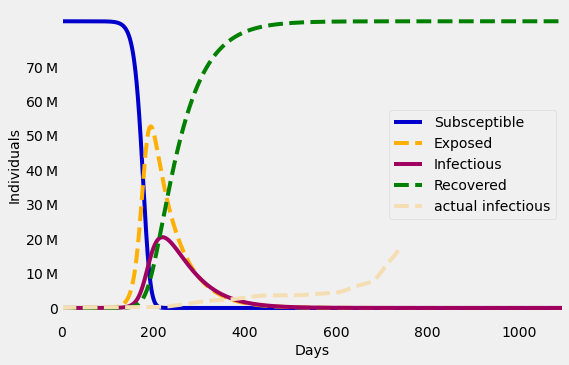

In [148]:
# Preparing data parsing for SEIR
data_set_name = "SEIR"
data_directory_name = "./data/" + data_set_name + "/"
data_directory = os.fsencode(data_directory_name)

test = True

for file in os.listdir(data_directory):
    data_filename = os.fsdecode(file)
    if data_filename.endswith(".csv"):

        # Parsing the seir data
        data_filename_prefix = data_filename.split(".")[0]      
        packed_data = data_reader.read_seir_from_csv_file(data_directory_name + data_filename_prefix + ".csv")

        # Unpacking some of the parsed data
        n = packed_data[0]
        x0 = packed_data[-1]

        print("Setting up the SEIR model")
        ode_system = SEIR_Model(packed_data)
        
        # Solve the ODE system
        explicit_euler = Explicit_Euler(ode_system, stepsize)
        start_time = time.time()
        results = explicit_euler.solve(t_start, x0, t_end)
        end_time = time.time()
        print("Required CPU time = " + str(round(end_time - start_time, 3)) + " seconds")

        # Analyze results
        result_analyzer = SEIR_Result_Analyzer(results, stepsize, n, t_start, t_end)
        result_analyzer.extract_results()
        result_dict = result_analyzer.get_extracted_results_as_dict()
        result_analyzer.compute_and_write_results()

        # Visualize results
        visualizer = SEIR_Visualizer(result_dict, n, t_start, t_end)

        visualizer.plot_curves()


Parse SEIIRHQ data from CSV file ./data/SEIIRHQ/seiirhq_szenario.csv ...
Setting up the SEIIRHQ Model model
Running in test mode.
Instantiate the SEIIRHQ model ...
Solve model with explicit Euler scheme ...
Number of steps: 109501
Required CPU time = 1.639 seconds
Dauer der Simulation in Tagen: 1095
Dauer der Pandemie: mehr als  1095.0 Tage
Die Pandemie ist am letzen Simulationstag noch nicht zu Ende


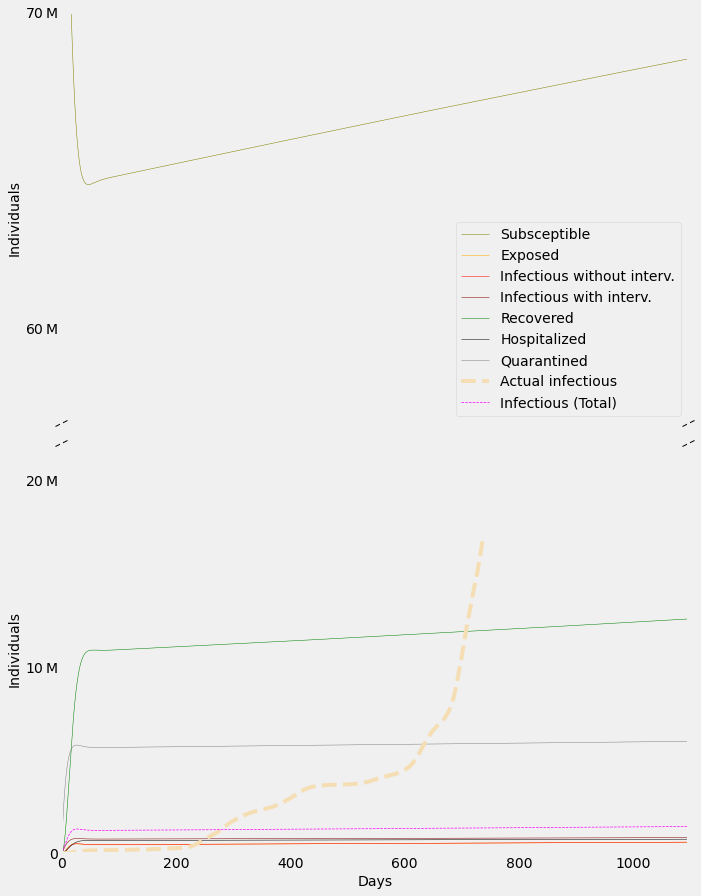

In [149]:
# Preparing data parsing for SEIIRHQ
data_set_name = "SEIIRHQ"
data_directory_name = "./data/" + data_set_name + "/"
data_directory = os.fsencode(data_directory_name)

test = True

for file in os.listdir(data_directory):
    data_filename = os.fsdecode(file)
    if data_filename.endswith(".csv"):

        # Parsing the seiirhq data
        data_filename_prefix = data_filename.split(".")[0]
        
        packed_data = data_reader.read_seiirhq_from_csv_file(data_directory_name + data_filename_prefix + ".csv")

        # Unpacking some of the parsed data
        n = packed_data[0]
        x0 = packed_data[-1]

        print("Setting up the SEIIRHQ Model model")
        ode_system = SEIIRHQ_Model(packed_data)
        
        # Solve the ODE system
        explicit_euler = Explicit_Euler(ode_system, stepsize)
        start_time = time.time()
        results = explicit_euler.solve(t_start, x0, t_end)
        end_time = time.time()
        print("Required CPU time = " + str(round(end_time - start_time, 3)) + " seconds")

        # Analyze results
        result_analyzer = SEIIRHQ_Result_Analyzer(results, stepsize, n, t_start, t_end)
        result_analyzer.extract_results()
        result_dict = result_analyzer.get_extracted_results_as_dict()
        result_analyzer.compute_and_write_results()

        # Visualize results
        visualizer = SEIIRHQ_Visualizer(result_dict, n, t_start, t_end)

        visualizer.plot_curves()


Parse SSSEIIRQH data from CSV file ./data/SSSEIIRHQ/ssseiirhq_szenario.csv ...
Setting up the SSSEIRHQ model
Instantiate the SSSEIIRHQ model ...
Running in test mode.
Solve model with explicit Euler scheme ...
Number of steps: 109501
Required CPU time = 2.269 seconds
Dauer der Simulation in Tagen: 1095
Dauer der Pandemie: mehr als  1095.0 Tage
Die Pandemie ist am letzen Simulationstag noch nicht zu Ende


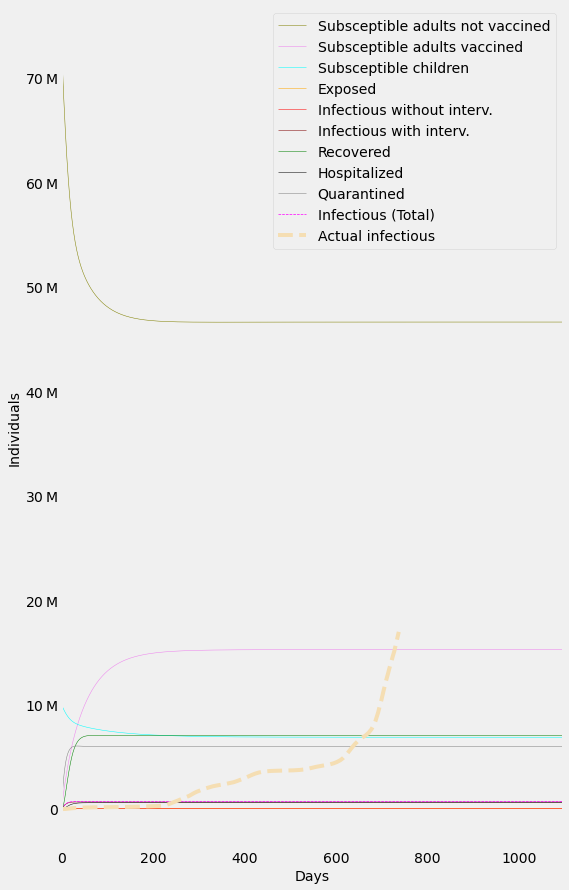

In [150]:
# Preparing data parsing for SSSEIIRHQ
data_set_name = "SSSEIIRHQ"
data_directory_name = "./data/" + data_set_name + "/"
data_directory = os.fsencode(data_directory_name)

test = True

for file in os.listdir(data_directory):
    data_filename = os.fsdecode(file)
    if data_filename.endswith(".csv"):

        # Parsing the ssseiirhq data
        data_filename_prefix = data_filename.split(".")[0]
        
        packed_data = data_reader.read_ssseiirhq_from_csv_file(data_directory_name + data_filename_prefix + ".csv")

        # Unpacking some of the parsed data
        n = packed_data[0]
        x0 = packed_data[-1]
        print("Setting up the SSSEIRHQ model")
        ode_system = SSSEIIRHQ_Model(packed_data)
        
        # Solve the ODE system
        explicit_euler = Explicit_Euler(ode_system, stepsize)
        start_time = time.time()
        results = explicit_euler.solve(t_start, x0, t_end)
        end_time = time.time()
        print("Required CPU time = " + str(round(end_time - start_time, 3)) + " seconds")

        # Analyze results
        result_analyzer = SSSEIIRHQ_Result_Analyzer(results, stepsize, n, t_start, t_end)
        result_analyzer.extract_results()
        result_dict = result_analyzer.get_extracted_results_as_dict()
        result_analyzer.compute_and_write_results()

        # Visualize results
        visualizer = SSSEIIRHQ_Visualizer(result_dict, n, t_start, t_end)
        visualizer.plot_curves()
          

## Diskussion und Fazit
Eine zunehmend detailliertere Betrachtung der Deutschen Bevölkerung ermöglich ein genaueres Verständnis des Pandemieverlaufes im Vergleich zum "einfachen" SEIR Modell. Insbesondere die Modellierung verschiedener Krankheitsverläufe, sowie die Differenzierung nach unterschiedlich gefährdeten Bevölkerungsgruppen wird der Gesamtgesellschaftlichen Debatte um das Coronavirus deutlich besser gerecht, als das ursprüngliche SEIR Modell. 
Im Umgang mit dem Coronavirus gibt es 3 erstrebenswerte Ziele, die sich aber gegenseitig ausschließen:
1. Ein schnelles Ende der Pandemie
2. Die Überlastung der Intensivstationen verhindern
3. Möglichst geringe Todeszahlen

Maßnahmen der Pandemieeinämmung ("Lockdowns") verlängern dabei die Dauer der Pandemie, senken aber im Gegenzug die Todeszahlen und verhindern eine Überlastund des Gesundheitssystems. Im Vergleich mit der tatsächlichen Realität zeigt sich dabei, dass die Pandemie bereits deutlich länger andauert, als die verschiedenen SEIR Modelle das vorhergesagt haben, und es aber insgesamt deutlich weniger erkranke Personen gibt. 
So gibt es im ursprünglichen SEIR Modell in Spitze über 50 Millionen "Exposed" Personen. Diese Vorstellung wäre in der Realität eine gesellschaftliche Katastrophe, mit unseren Anpassungen des Modells konnten wir der Realität deutlich näher kommen
Gründe für längere Dauer der Pandemie sind vermutlich neben den Lockdown-Maßnahmen insbesondere die verschiedenen Corona Varianten, sowie die Möglichkeit, mehrfach an Corona zu erkranken. Diese beiden Aspekte sind allerdings jenseits des Horizontes dieser Ausarbeitung



## Quellen:
- https://de.wikipedia.org/wiki/SEIR-Modell
- https://de.wikipedia.org/wiki/Explizites_Euler-Verfahren
- https://link.springer.com/article/10.1007/s11071-020-05743-y
- https://www.nature.com/articles/s41598-021-83540-2
- https://github.com/m-schmidt-math-opt/covid-19-extended-seir-model
